In [1]:
# Third-party
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from pyia import GaiaData

Omega cen cluster phase-space coordinates from Eugene Vasiliev:

In [3]:
globclust = Table.read('/Users/adrian/data/Misc/Vasiliev-globclust.txt', format='ascii.fixed_width')
cs = coord.SkyCoord(ra=globclust['RA']*u.deg, 
                    dec=globclust['DEC']*u.deg,
                    distance=globclust['D']*u.kpc,
                    pm_ra_cosdec=globclust['PMRA']*u.mas/u.yr,
                    pm_dec=globclust['PMDEC']*u.mas/u.yr,
                    radial_velocity=globclust['Vlos']*u.km/u.s)

In [7]:
c = cs[globclust['Name'] == 'NGC 5139 (omega Cen)']
c

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(201.697, -47.48, 5.2)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-3.215, -6.761, 232.7)]>

In [8]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

Generate Galactocentric orbital initial conditions for Omega cen:

In [9]:
w0 = gd.PhaseSpacePosition(c.transform_to(galcen_frame).data)

Define a mass model for the Milky Way:

In [17]:
mw = gp.MilkyWayPotential()
H = gp.Hamiltonian(mw)
for k in mw:
    print(repr(mw[k]))

<MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>
<HernquistPotential: m=5.00e+09, c=1.00 (kpc,Myr,solMass,rad)>
<HernquistPotential: m=1.71e+09, c=0.07 (kpc,Myr,solMass,rad)>
<NFWPotential: m=5.40e+11, r_s=15.62 (kpc,Myr,solMass,rad)>


Integrate the orbit of Omega Cen backwards in time:

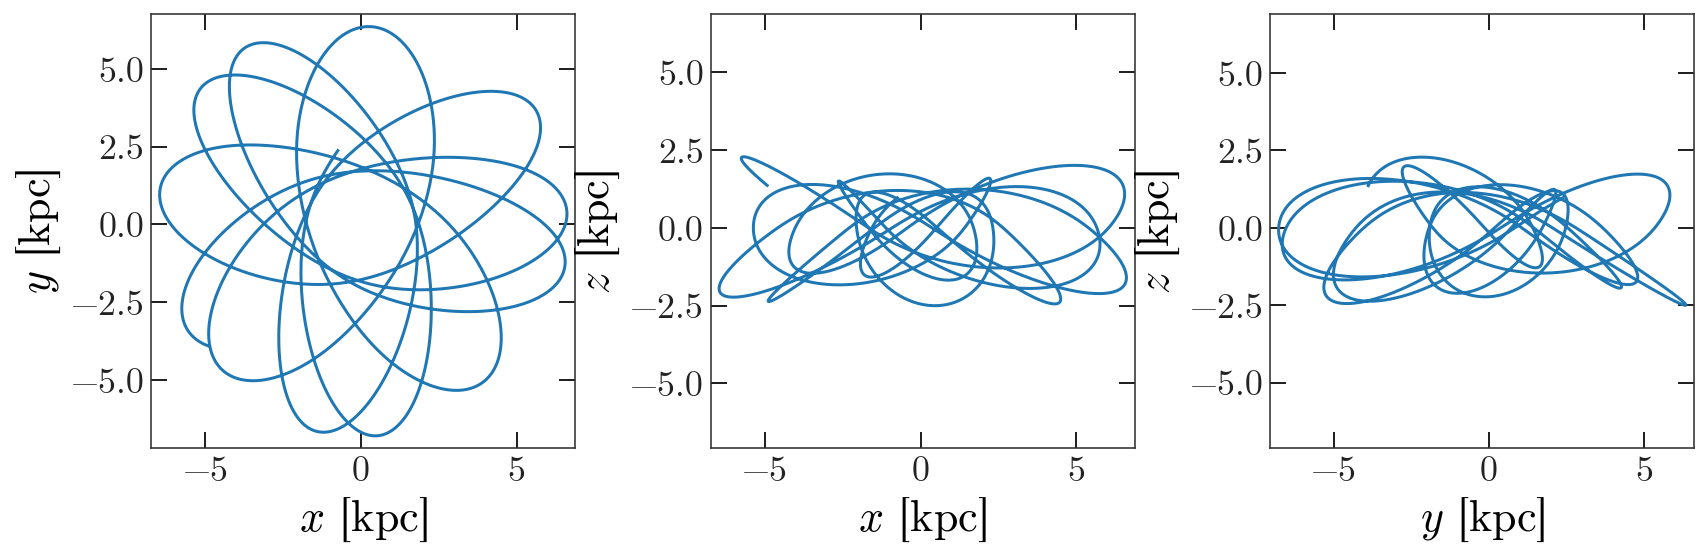

In [37]:
orbit = H.integrate_orbit(w0, dt=-0.5, t1=0, t2=-1*u.Gyr)
_ = orbit.plot()

Now generate a mock stream going forward in time:

In [38]:
from gala.dynamics.mockstream import fardal_stream

In [44]:
stream = fardal_stream(H, orbit[::-1], prog_mass=5e5*u.Msun, release_every=1)

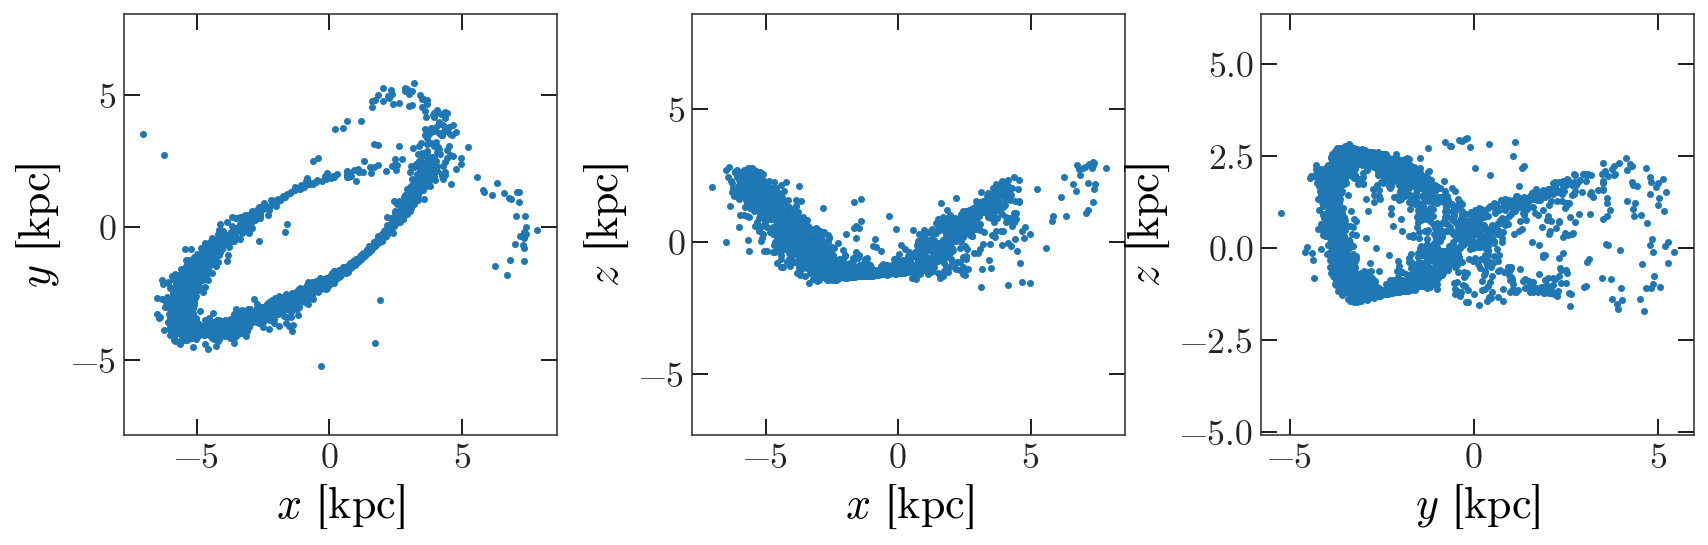

In [45]:
_ = stream.plot()

In [46]:
stream_icrs = stream.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

Text(0.5,0,'$\\alpha$')

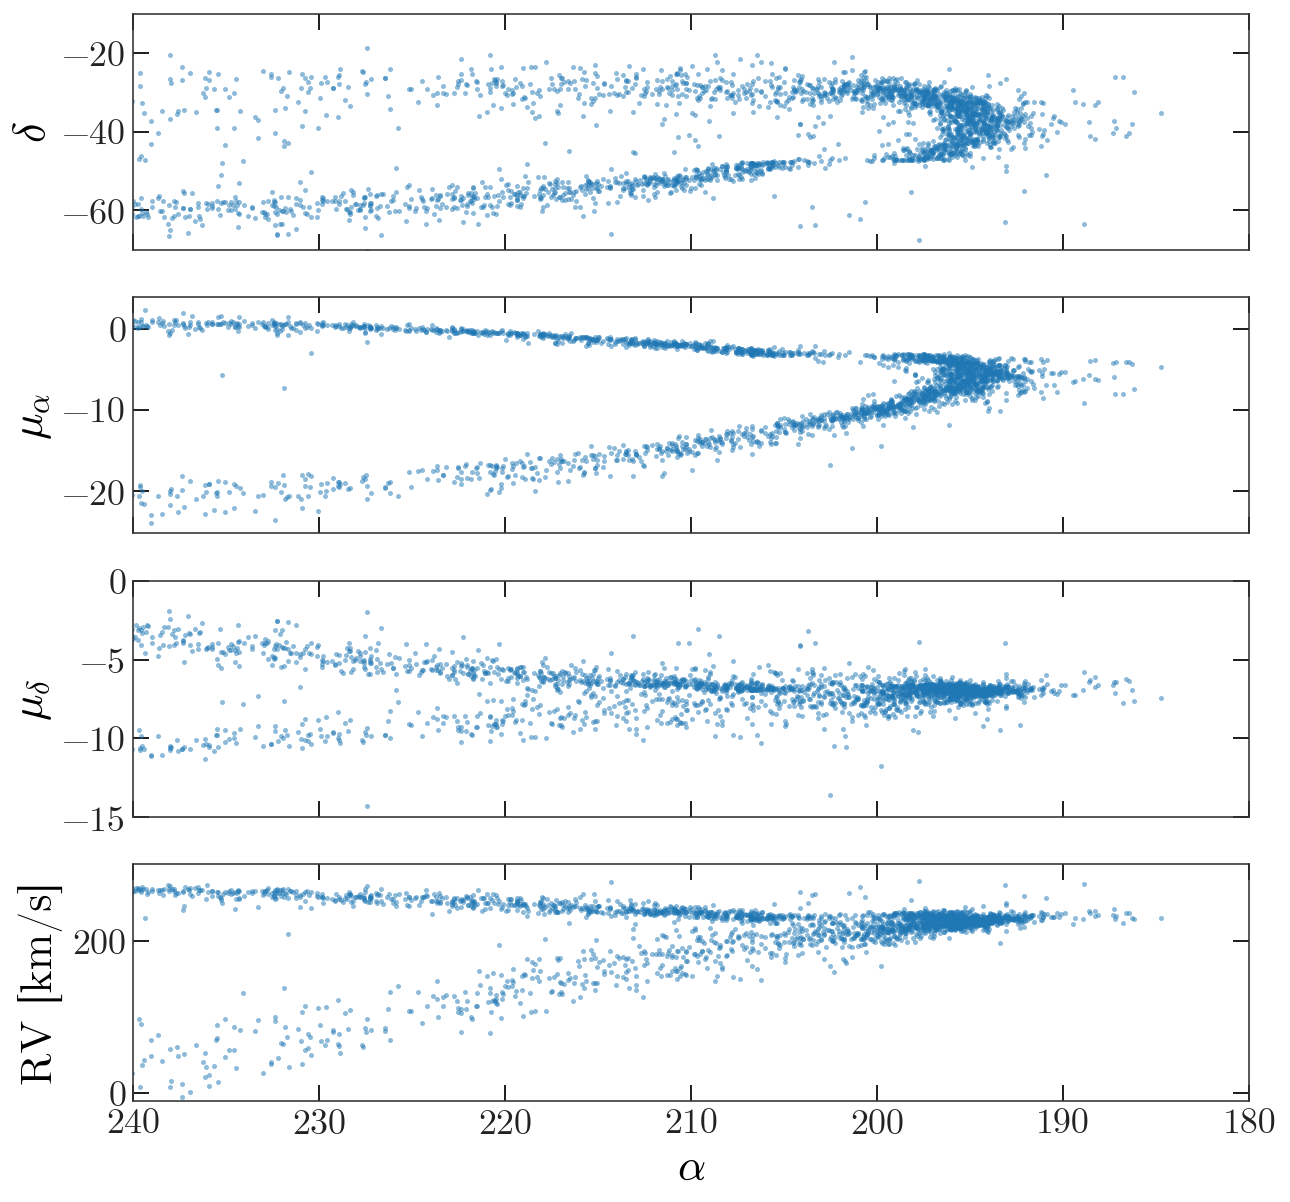

In [56]:
style = dict(marker='o', ls='none', alpha=0.5, mew=0, ms=2.5)

fig, axes = plt.subplots(4, 1, figsize=(10, 10), 
                         sharex=True)

ax = axes[0]
ax.plot(stream_icrs.ra.degree,
        stream_icrs.dec.value,
        **style)
ax.set_ylim(-70, -10)
ax.set_ylabel(r'$\delta$')

ax = axes[1]
ax.plot(stream_icrs.ra.degree,
        stream_icrs.pm_ra_cosdec.value,
        **style)
ax.set_ylabel(r'$\mu_\alpha$')

ax = axes[2]
ax.plot(stream_icrs.ra.degree,
        stream_icrs.pm_dec.value,
        **style)
ax.set_ylim(-15, 0)
ax.set_ylabel(r'$\mu_\delta$')

ax = axes[3]
ax.plot(stream_icrs.ra.degree,
        stream_icrs.radial_velocity.value,
        **style)
ax.set_ylim(-10, 300)
ax.set_ylabel('RV [km/s]')

ax.set_xlim(240, 180)
ax.set_xlabel(r'$\alpha$')